# Import

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import gym

# Actor-Critic networks

In [2]:
# Check if the GPU is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
# Used for initialize final layer weights and biases of actor and critic
WEIGHT_FINAL_LAYER = 3e-3
BIAS_FINAL_LAYER   = 3e-4

cuda


In [3]:
class Actor(nn.Module):
  def __init__(self, input_shape, hidden_shape, num_actions, lr, filepath='./actor'):
    super(Actor, self).__init__()
    self.input_shape = input_shape
    self.hidden_shape = hidden_shape
    self.num_actions = num_actions
    self.filepath = filepath

    # Layer 1
    self.fc1 = nn.Linear(self.input_shape, hidden_shape[0])
    self.bn1 = nn.LayerNorm(hidden_shape[0])
    # Layer 2
    self.fc2 = nn.Linear(hidden_shape[0], hidden_shape[1])
    self.bn2 = nn.LayerNorm(hidden_shape[1])
    # Output Layer - mu
    self.mu = nn.Linear(hidden_shape[1], num_actions)

    self.optimizer = optim.Adam(self.parameters(), lr)
    self.to(DEVICE)

  def init_weight_bias(self):
    # Weights and biases initialization
    fan_in_weight_1 = 1/np.sqrt(self.fc1.weight.data.size()[0])
    fan_in_bias_1 = 1/np.sqrt(self.fc1.bias.data.size()[0])
    nn.init.uniform_(self.fc1.weight, -fan_in_weight_1, fan_in_weight_1)
    nn.init.uniform_(self.fc1.bias, -fan_in_bias_1, fan_in_bias_1)

    fan_in_weight_2 = 1/np.sqrt(self.fc2.weight.data.size()[0])
    fan_in_bias_2 = 1/np.sqrt(self.fc2.bias.data.size()[0])
    nn.init.uniform_(self.fc2.weight, -fan_in_weight_2, fan_in_weight_2)
    nn.init.uniform_(self.fc2.bias, -fan_in_bias_2, fan_in_bias_2)

    nn.init.uniform_(self.mu.weight, -WEIGHT_FINAL_LAYER, WEIGHT_FINAL_LAYER)
    nn.init.uniform_(self.mu.bias, -BIAS_FINAL_LAYER, BIAS_FINAL_LAYER)

  def forward(self, state):
    x = self.fc1(state)
    x = self.bn1(x)
    x = nn.functional.relu(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = nn.functional.relu(x)

    # Output
    mu = torch.tanh(self.mu(x))
    return mu

  def save_model(self):
    torch.save(self.state_dict(), self.filepath)

  def load_model(self):
    torch.save(self.state_dict(), self.filepath)

In [4]:
class Critic(nn.Module):
  def __init__(self, input_shape, hidden_shape, num_actions, lr, l2, filepath='./critic'):
    super(Critic, self).__init__()
    self.input_shape = input_shape
    self.hidden_shape = hidden_shape
    self.num_actions = num_actions
    self.filepath = filepath

    # Layer 1
    self.fc1 = nn.Linear(self.input_shape, self.hidden_shape[0])
    self.bn1 = nn.LayerNorm(self.hidden_shape[0])
    # Layer 2
    self.fc2 = nn.Linear(self.hidden_shape[0] + num_actions, self.hidden_shape[1])
    self.bn2 = nn.LayerNorm(self.hidden_shape[1])
    # Output layer - Q
    self.Q = nn.Linear(self.hidden_shape[1], 1)

    self.optimizer = optim.Adam(self.parameters(), lr, weight_decay=l2)
    self.to(DEVICE)

  def init_weight_bias(self):
    # Weights and biases initialization
    fan_in_weight_1 = 1/np.sqrt(self.fc1.weight.data.size()[0])
    fan_in_bias_1 = 1/np.sqrt(self.fc1.bias.data.size()[0])
    nn.init.uniform_(self.fc1.weight, -fan_in_weight_1, fan_in_weight_1)
    nn.init.uniform_(self.fc1.bias, -fan_in_bias_1, fan_in_bias_1)

    fan_in_weight_2 = 1/np.sqrt(self.fc2.weight.data.size()[0])
    fan_in_bias_2 = 1/np.sqrt(self.fc2.bias.data.size()[0])
    nn.init.uniform_(self.fc2.weight, -fan_in_weight_2, fan_in_weight_2)
    nn.init.uniform_(self.fc2.bias, -fan_in_bias_2, fan_in_bias_2)

    nn.init.uniform_(self.Q.weight, -WEIGHT_FINAL_LAYER, WEIGHT_FINAL_LAYER)
    nn.init.uniform_(self.Q.bias, -BIAS_FINAL_LAYER, BIAS_FINAL_LAYER)

  def forward(self, state, actions):
    x = self.fc1(state)
    x = self.bn1(x)
    x = nn.functional.relu(x)

    x = torch.cat((x, actions), 1)
    x = self.fc2(x)
    x = self.bn2(x)
    x = nn.functional.relu(x)

    # Output
    output = self.Q(x)
    return output

  def save_model(self):
    torch.save(self.state_dict(), self.filepath)

  def load_model(self):
    torch.save(self.state_dict(), self.filepath)


# Ornstein-Uhlenbeck noise

In [5]:
class OUNoise(object):
  def __init__(self, mu, sigma=0.2, theta=.15, dt=1e-2, x0=None):
    self.theta = theta
    self.mu = mu
    self.sigma = sigma
    self.dt = dt
    self.x0 = x0
    self.reset()

  def __call__(self):
    x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
        self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
    self.x_prev = x
    return x

  def reset(self):
    self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

  def __repr__(self):
    return 'OrnsteinUhlenbeckNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


# Replay Buffer

In [6]:
class ReplayBuffer(object):
  def __init__(self, max_size, input_shape, num_actions):
    self.mem_size = max_size
    self.mem_cntr = 0
    self.state_mem = np.zeros((self.mem_size, input_shape)) 
    self.new_state_mem = np.zeros((self.mem_size, input_shape))
    self.action_mem = np.zeros((self.mem_size, num_actions))
    self.reward_mem = np.zeros(self.mem_size)
    self.terminal_mem = np.zeros(self.mem_size)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size #first available position
    self.state_mem[index] = state
    self.new_state_mem[index] = state_
    self.reward_mem[index] = reward
    self.action_mem[index] = action
    self.terminal_mem[index] = 1 - int(done)
    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size)

    states = self.state_mem[batch]
    new_states = self.new_state_mem[batch]
    actions = self.action_mem[batch]
    rewards = self.reward_mem[batch]
    terminal = self.terminal_mem[batch]

    return states, actions, rewards, new_states, terminal

# DDPG

In [7]:
class DDPG(object):
  def __init__(self, input_shape, num_actions, action_space,lr_actor=1e-4, lr_critic=1e-3, l2_critic=1e-2, 
               gamma=0.99, tau=1e-3, hidden_shape=([400,300]), batch_size=64, rbuffer_size=10**6):
    self.gamma = gamma
    self.tau = tau
    self.input_shape = input_shape
    self.batch_size = batch_size
    self.action_space = action_space

    # Intialize critic network Q(s,a|theta^Q) and target network Q'
    self.critic = Critic(self.input_shape, hidden_shape, num_actions, lr_critic, l2_critic)
    self.critic_target = Critic(self.input_shape, hidden_shape, num_actions, lr_critic, l2_critic)
    
    # Intialize actor network mu(s|theta^mu) and target network mu'
    self.actor = Actor(self.input_shape, hidden_shape, num_actions, lr_actor)
    self.actor_target = Actor(self.input_shape, hidden_shape, num_actions, lr_actor)

    # Make sure targets have the same weight
    self.update_target_params(self.critic, self.critic_target, 1)
    self.update_target_params(self.actor, self.actor_target, 1)

    # Initialize replay buffer
    self.replay_buffer = ReplayBuffer(rbuffer_size, input_shape, num_actions)

    self.noise = OUNoise(mu=np.zeros(num_actions))


  def select_action(self, observation):
    # evaluate the model (turn off batch norm)
    self.actor.eval()

    observation = torch.tensor(observation, dtype=torch.float).to(DEVICE)
    mu = self.actor(observation).to(DEVICE)
    mu_prime = mu + torch.tensor(self.noise(), dtype=torch.float).to(DEVICE)

    # Clip the output according to the action space of the env
    mu_prime = mu_prime.clamp(self.action_space.low[0], self.action_space.high[0])
    self.actor.train()

    return mu_prime.cpu().detach().numpy() # We cannot pass a tensor to openai gym


  def save_transition(self, state, action, reward, new_state, done):
    self.replay_buffer.store_transition(state, action, reward, new_state, done)


  def learn(self):
    if self.replay_buffer.mem_cntr < self.batch_size: 
      return
    # Sample random minibatch of N=batch_size transitions (s_i, a_i, r_i, s_(i+1)) from the replay buffer
    state, action, reward, new_state, done = self.replay_buffer.sample_buffer(self.batch_size)

    state = torch.tensor(state, dtype=torch.float).to(DEVICE)
    action = torch.tensor(action, dtype=torch.float).to(DEVICE)
    reward = torch.tensor(reward, dtype=torch.float).to(DEVICE)
    new_state = torch.tensor(new_state, dtype=torch.float).to(DEVICE)
    done = torch.tensor(done, dtype=torch.float).to(DEVICE)

    self.nn_eval()

    # Compute mu'(s_(i+1)|theta^mu')
    mu_prime = self.actor_target(new_state)
    # Compute Q'(s_(i+1),mu'(s_(i+1)|theta^mu')|theta^Q')
    Q_prime = self.critic_target(new_state, mu_prime)

    # Set y_i = r_i + gamma*Q'(s_(i+1),mu'(s_(i+1)|theta^mu')|theta^Q')
    y = []
    for i in range(self.batch_size):
      y.append(reward[i] + self.gamma*Q_prime[i] * done[i]) # We don't keep new rewarding after terminal state
    target = torch.tensor(y).to(DEVICE)
    target = target.view(self.batch_size, 1) # Reshape the tensor

    # Update the critic by minimizing the loss
    self.critic.train()
    self.critic.optimizer.zero_grad() # zero_grad clears old gradients from the last step
    Q = self.critic(state, action) # Compute Q(s_i,a_i|theta^Q)
    value_loss = nn.functional.mse_loss(target, Q) # L
    value_loss.backward() # computes the derivative of the loss wrt the parameters using backpropagation
    self.critic.optimizer.step() # causes the optimizer to take a step based on the gradients of the parameters

    # Update the actor policy using the sampled policy gradient
    self.critic.eval()
    self.actor.optimizer.zero_grad()
    mu = self.actor(state)
    self.actor.train()
    policy_loss = -self.critic(state, mu)
    policy_loss = torch.mean(policy_loss)
    policy_loss.backward()
    self.actor.optimizer.step()

    self.update_target_params(self.critic, self.critic_target)
    self.update_target_params(self.actor, self.actor_target)

  def update_target_params(self, source, target, tau=None):
    if tau == None:
      # Perform soft update, otherwise hard update
      tau = self.tau
    for target_param, param in zip(target.parameters(), source.parameters()):
      target_param.data.copy_(param.data*tau + (1-tau)*target_param.data)

  def nn_eval(self):
    self.critic.eval()
    self.critic_target.eval()
    self.actor.eval()
    self.actor_target.eval()
    
  def save_models(self):
    self.actor.save_model()
    self.target_actor.save_model()
    self.critic.save_model()
    self.target_critic.save_model()

  def load_models(self):
    self.actor.load_model()
    self.target_actor.load_model()
    self.critic.load_model()
    self.target_critic.load_model()


# Train

In [8]:
MAX_EPISODES = 200
MAX_TIMESTEPS = 50
NUM_UPDATES = 20
RENDER = True

In [9]:
def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

In [10]:
env = gym.make('FetchPickAndPlace-v1')
env.reset()

input_shape = env.observation_space['observation'].shape[0]
num_actions = env.action_space.shape[0]
agent = DDPG(input_shape, num_actions, env.action_space)

print(env.reset())

Exception: 
Missing path to your environment variable. 
Current values LD_LIBRARY_PATH=
Please add following line to .bashrc:
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/salvatore/.mujoco/mujoco200/bin

In [ ]:
score_history = []
for i in range(MAX_EPISODES):
    env_dict = env.reset()
    observation = env_dict['observation']
    achieved_goal = env_dict['achieved_goal']
    desired_goal  = env_dict['desired_goal']
    done = False
    score = 0

    # print("Start Episode",i," achieved_goal:", achieved_goal)
    # print("Start Episode",i," desired_goal:", desired_goal)
    while not done:
        # for t in range(MAX_TIMESTEPS):
        act = agent.select_action(observation)
        new_env_dict, reward, done, info = env.step(act)

        new_state = new_env_dict['observation']
        new_achieved_goal = new_env_dict['achieved_goal']
        new_desired_goal  = new_env_dict['desired_goal']
        

    # for t in range(MAX_TIMESTEPS):

        agent.save_transition(observation, act, reward, new_state, int(done))

    # for n in range(NUM_UPDATES):
        agent.learn()
        score += reward
        observation = new_state


        if RENDER:
            env.render()

    env.close()
    
    # print("Finish Episode",i," new_achieved_goal:", new_achieved_goal)
    # print("Finish Episode",i," new_desired_goal:", new_desired_goal)
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-100:]))

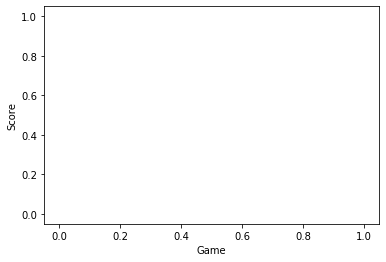

In [12]:
filename = 'FetchPickAndPlace1.png'
plotLearning(score_history, filename, window=100)

# DDPG + HER Train

In [13]:
def sample_goals(state):


SyntaxError: unexpected EOF while parsing (<ipython-input-13-d05406b1e803>, line 1)

In [ ]:
def compute_reward(achieved_goal, goal):
    if norm achieved_goal, goal < tolerance:
        reward = 0
    else:
        reward = 1


In [11]:
env_her = gym.make('FetchPickAndPlace-v1')
env_her.reset()

input_shape = env_her.observation_space['observation'].shape[0]
num_actions = env_her.action_space.shape[0]
agent_her = DDPG(input_shape, num_actions, env_her.action_space)

print(env_her.reset())

{'observation': array([ 1.34193265e+00,  7.49100375e-01,  5.34722720e-01,  1.37480448e+00,
        8.95516720e-01,  4.24702091e-01,  3.28718331e-02,  1.46416345e-01,
       -1.10020629e-01,  2.91834773e-06, -4.72661656e-08, -3.85214084e-07,
        5.92637053e-07,  1.12208536e-13, -7.74656889e-06, -7.65027248e-08,
        4.92570535e-05,  1.88857148e-07, -2.90549459e-07, -1.18156686e-18,
        7.73934983e-06,  7.18103404e-08, -2.42928780e-06,  4.93607091e-07,
        1.70999820e-07]), 'achieved_goal': array([1.37480448, 0.89551672, 0.42470209]), 'desired_goal': array([1.23442502, 0.87288161, 0.42469975])}


In [12]:
score_history_her = []
for i in range(1):
    env_dict = env_her.reset()
    observation = env_dict['observation']
    achieved_goal = env_dict['achieved_goal']
    desired_goal  = env_dict['desired_goal']
    done = False
    score = 0

    # print("Start Episode",i," achieved_goal:", achieved_goal)
    # print("Start Episode",i," desired_goal:", desired_goal)
    while not done:
        # env_previous = env_her # Save the environment before the action

        act = agent_her.select_action(observation)
        new_env_dict, reward, done, info = env_her.step(act)

        # env_after_action = env_her # Save the environment after the performed action

        new_state = new_env_dict['observation']
        new_achieved_goal = new_env_dict['achieved_goal']
        new_desired_goal  = new_env_dict['desired_goal']
        
        agent_her.save_transition(observation, act, reward, new_state, int(done))

        # If we want, we can substitute a goal here and re-compute
        # the reward. For instance, we can just pretend that the desired
        # goal was what we achieved all along.
        substitute_goal = new_env_dict['achieved_goal'].copy()
        print(substitute_goal)
        substitute_reward = env_her.compute_reward(new_env_dict['achieved_goal'], substitute_goal, info)
        print('reward is {}, substitute_reward is {}'.format(reward, substitute_reward))

        # extra_goals = sample_goals(i, trajectory)
        # for extra_goal in extra_goals:
        #     env = env_previous

        #     extra_reward = compute_reward(observation, act, extra_goal)
        #     agent_her.save_transition(extra_goal, obs, action, extra_reward, next_obs, done)
            
        #     env = env_after_action

        agent_her.learn()
        score += reward
        observation = new_state


        if RENDER:
            env_her.render()


    env.close()
    
    # print("Finish Episode",i," new_achieved_goal:", new_achieved_goal)
    # print("Finish Episode",i," new_desired_goal:", new_desired_goal)
    score_history_her.append(score)

    #if i % 25 == 0:
    #    agent_her.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history_her[-100:]))
          

reward is -1.0, substitute_reward is -0.0
Creating window glfw
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.0, substitute_reward is -0.0
reward is -1.

In [ ]:
filename_her = 'FetchPickAndPlace1HER.png'
plotLearning(score_history_her, filename_her, window=100)

# Test trained model

In [ ]:
#Later to restore:
model.load_state_dict(torch.load(filepath))
model.eval()